In [1]:
import os
os.environ["MKL_INTERFACE_LAYER"] = "ILP64"

In [2]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import h5py
import hdf5plugin

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(1350, 1350, 7)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

In [3]:
e4m_mask = np.load(MASKS_folder + 'e4m_mask.npy')

# Generation of the e4m detector mask

This shuld account for all issues related only to the campera, i.e less or more sensitive areas, dead pixels, etc.

## Molybdenum foil scan (Mo_fluo_17p48keV, 1, 1)

In [5]:
#######################################
sample_name = 'Mo_fluo_17p48keV'
Ndataset = 1
Nscan = 1
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
itime = scan['elapsed_time'][1]-scan['elapsed_time'][0]
theta = scan['delcoup']

print('#############################')
print('command =', scan['command'])
print('itime =', itime)
print('theta =', theta)
print('#############################\n')

e4m_data = ID10.load_dense_e4m(RAW_folder, sample_name, Ndataset, Nscan)

#############################
command = loopscan 200 10
itime = 10.294816493988037
theta = 11.15
#############################

Loading dense array ...
	 -> loading file eiger4m_v2_frame_0_00000.h5 (1/1 loops)
Done! (elapsed time = 10.41 s)
Concatenating vectors ...
Done! (elapsed time = 0.42 s)
--------------------------------------------------------
Memory usage (numpy.array): 3.331 GB
--------------------------------------------------------


### Intensity stability by time

In [17]:
Idt = e4m_data[:,e4m_mask].sum(axis=1) / (e4m_mask.sum()*itime)

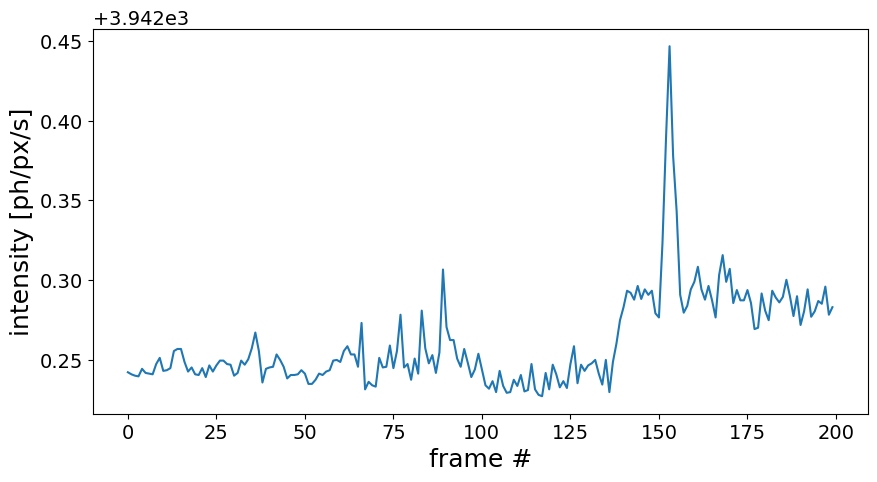

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(Idt)
#plt.ylim(0,10000)

plt.xlabel('frame #')
plt.ylabel('intensity [ph/px/s]')
plt.show()

### Scan averages

In [63]:
##################
Nf_th = 5/6
##################

Ip =      e4m_data[:int(Nf_th*e4m_data.shape[0]) ].sum(axis=0)/(int(Nf_th    *e4m_data.shape[0])*itime)
Ip_test = e4m_data[ int(Nf_th*e4m_data.shape[0]):].sum(axis=0)/(int((1-Nf_th)*e4m_data.shape[0])*itime)

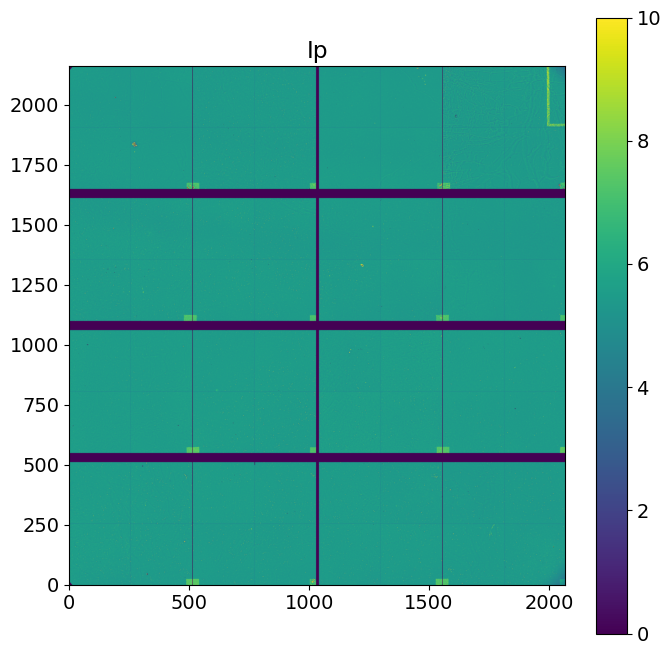

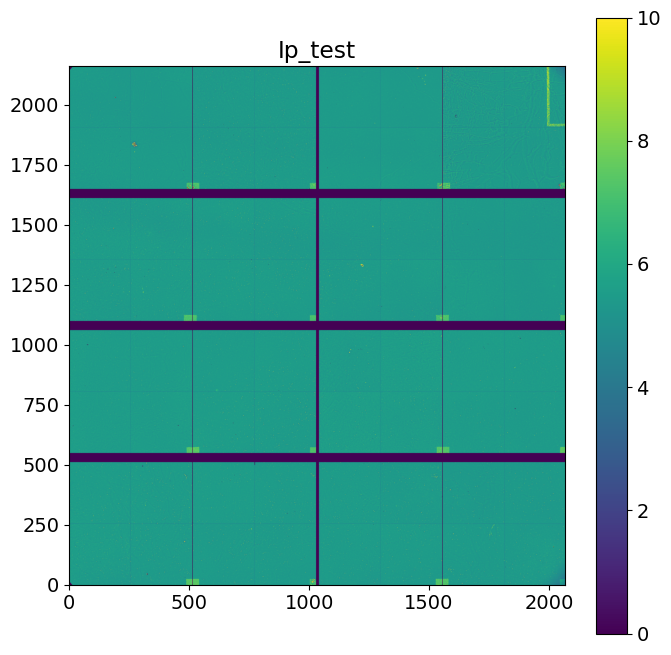

In [64]:
plt.figure(figsize=(8,8))
plt.imshow(Ip.reshape(Nx, Ny), vmin=0, vmax=10, origin='lower')
plt.colorbar()
plt.title('Ip')
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(Ip.reshape(Nx, Ny), vmin=0, vmax=10, origin='lower')
plt.colorbar()
plt.title('Ip_test')
plt.show()

## 1) Manual selection of areas of the detector

Use the flux and max maps with tight tresholds to underline the unwanted ares of the detector. Here we are looking for all kind of lines or strange large areas in the detector.
Use %matplotlib qt and high Nff to look at the maps!

### 1.1) Flux and max maps


################################################################################
Maximum count in the hull run -> 4294967300.0
# of pixels above Ith_high treshold ->  3650 pixels (of 4471016 => 0.08 %)
# of pixels below Ith_low treshold ->  269066 pixels (of 4471016 => 6.02 %)
# of pixels above Imaxth_high treshold ->  7256 pixels (of 4471016 => 0.16 %)
################################################################################



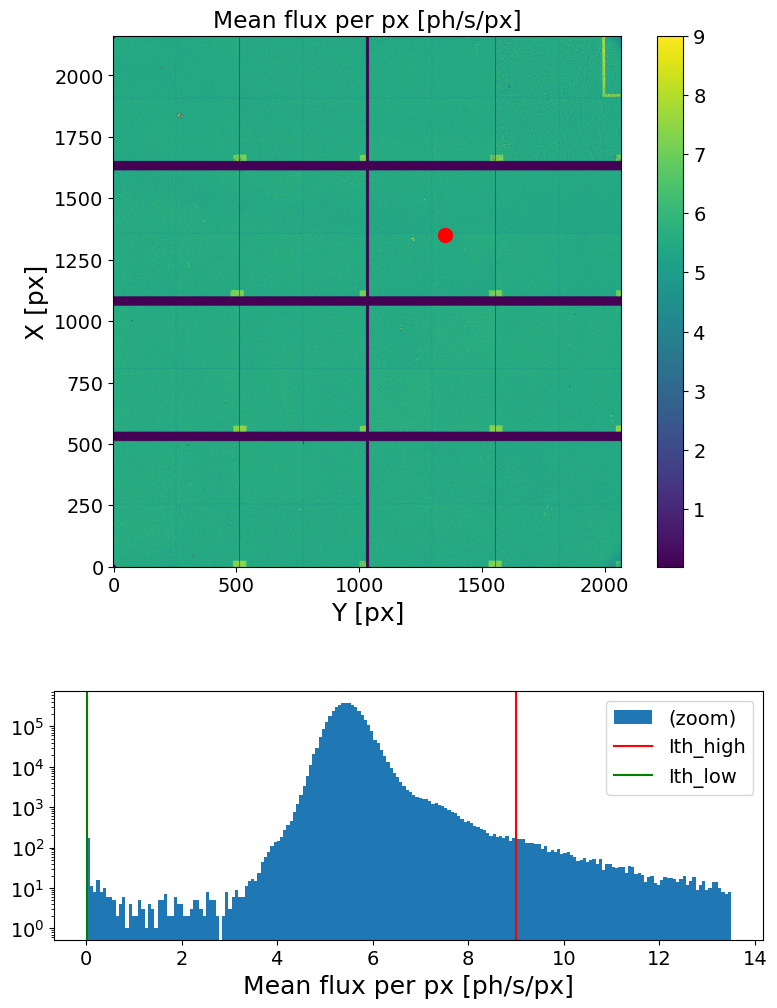

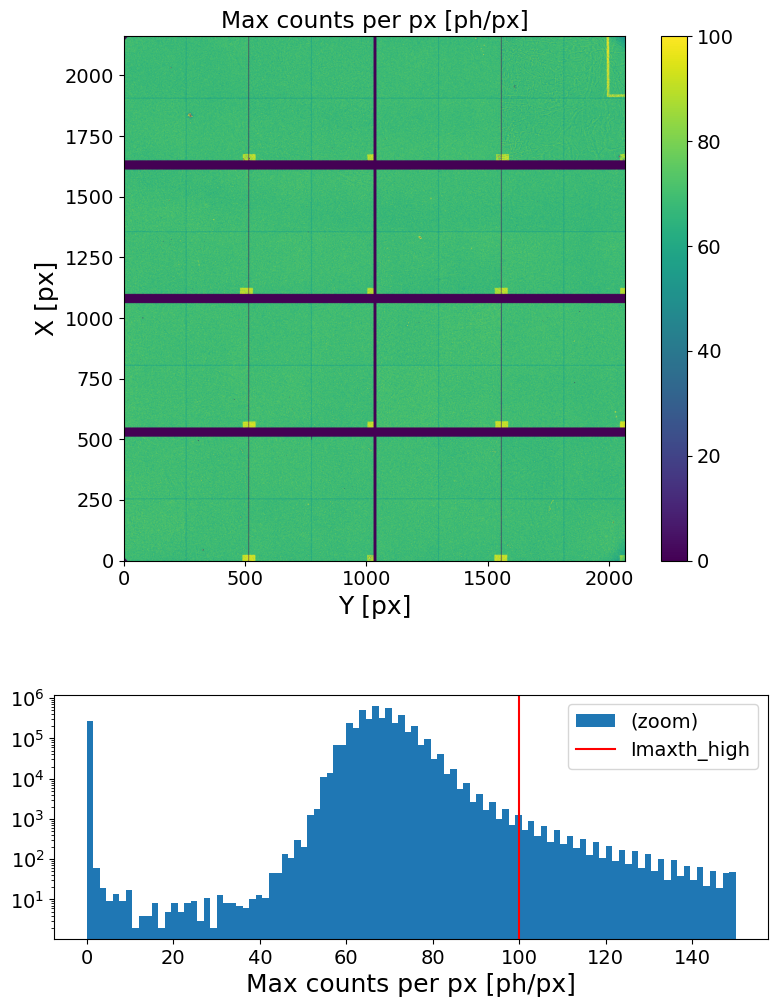

In [79]:
########################
Ith_low = .02
Ith_high = 9
Imaxth_high = 100
########################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high=Ith_high, Ith_low=Ith_low, Imaxth_high=Imaxth_high, Nfi=None, Nff=10, wide_plots=False, max_plots=True)

### 1.2) Mask manual definition

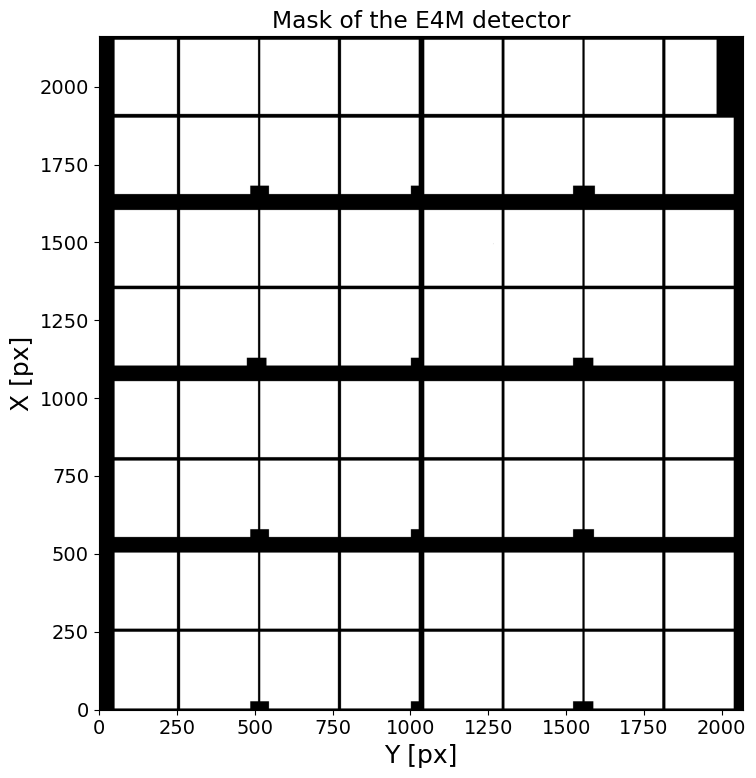

In [86]:
######## MASK OF LINES OF E4M DETECTOR ##########
e4m_mask = np.ones((Nx, Ny), dtype=bool)

# mask columns
e4m_mask[:, 510:517] = False
e4m_mask[:, 1025:1043] = False
e4m_mask[:, 1550:1557] = False

# mask rows
e4m_mask[505:555, :] = False
e4m_mask[1055:1105, :] = False
e4m_mask[1604:1655, :] = False

# mask borders
e4m_mask[:5, :] = False
e4m_mask[2150:, :] = False
e4m_mask[:, :50] = False
e4m_mask[:, 2035:] = False

# thin mask rows and columns at the center of the squares (visbile trhought max plots)
e4m_mask[251:261, :] = False
e4m_mask[800:811, :] = False
e4m_mask[1350:1361, :] = False
e4m_mask[1900:1912, :] = False

e4m_mask[:, 250:260] = False
e4m_mask[:, 766:776] = False
e4m_mask[:, 1291:1300] = False
e4m_mask[:, 1806:1816] = False
e4m_mask
# rectangles at the cross of row-columns borders
e4m_mask[:28,       485:545] = False
e4m_mask[540:580,   485:545] = False
e4m_mask[1090:1130, 474:537] = False
e4m_mask[1645:1682, 485:545] = False

e4m_mask[:28,       1000:1040] = False
e4m_mask[540:580,   1000:1040] = False
e4m_mask[1090:1130, 1000:1040] = False
e4m_mask[1645:1682, 1000:1040] = False

e4m_mask[:28,       1520:1585] = False
e4m_mask[540:580,   1520:1587] = False
e4m_mask[1090:1130, 1520:1585] = False
e4m_mask[1645:1682, 1520:1590] = False


# mask upright corner
e4m_mask[1900:, 1980:] = False

# remove higher-left rectangle
#e4m_mask[1640:, 1550:] = False

# remove single broken pixels
e4m_mask[15, 1007] = False
e4m_mask[15, 1008] = False
e4m_mask[16, 1008] = False
e4m_mask[1495, 1264] = False


e4m_mask = e4m_mask.flatten()
#################################################

# show the result
plt.figure(figsize=(8,8))
plt.imshow(e4m_mask.reshape(Nx, Ny), cmap='gray', origin='lower')
plt.title('Mask of the E4M detector')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

# save e4m_mask
np.save(MASKS_folder+'e4m_mask', e4m_mask)

### 1.3) Result on the same scan

################################################################################
Maximum count in the hull run -> 4294967300.0
# of pixels above Ith_high treshold ->  2428 pixels (of 4471016 => 0.07 %)
# of pixels below Ith_low treshold ->  259 pixels (of 4471016 => 0.01 %)
# of pixels above Imaxth_high treshold ->  2565 pixels (of 4471016 => 0.07 %)
################################################################################



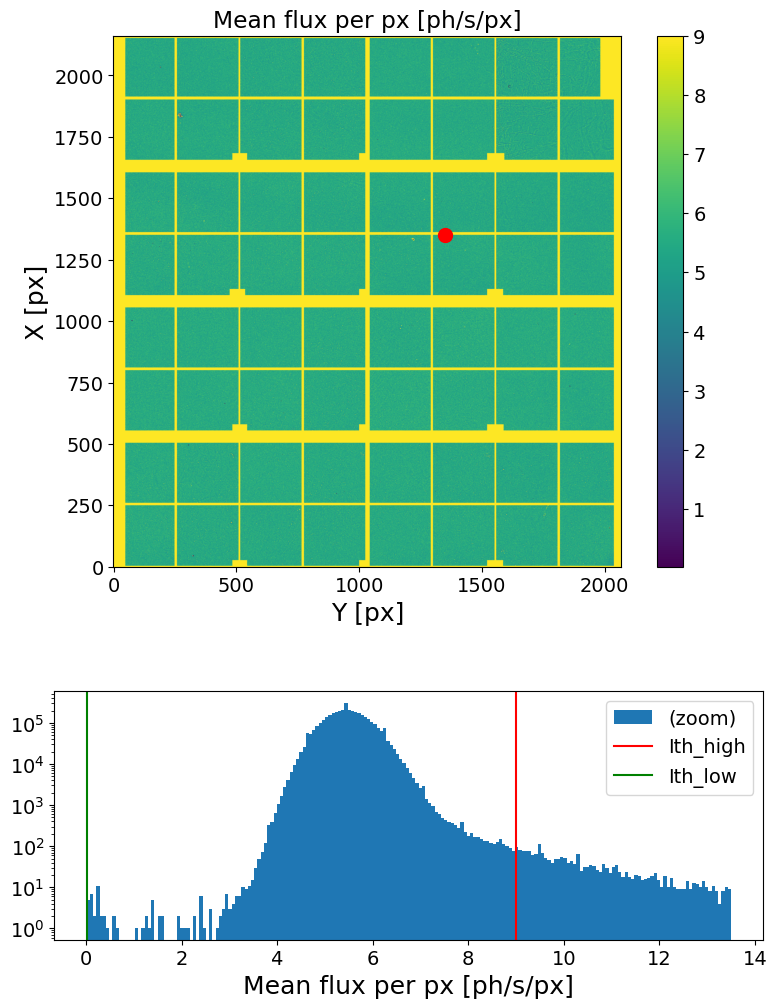

In [89]:
########################
Ith_low = .02
Ith_high = 9
Imaxth_high = 100
########################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high, Ith_low=Ith_low, Imaxth_high=Imaxth_high, mask=e4m_mask, Nfi=0, Nff=3, wide_plots=False, max_plots=False)

## 2) Hot/cold/non-flat pixels

Use strong treshold on the flux per px histogram around the signal distribution (in lin scale) to decouple the signal from the distribution of other noisy pixels.

Use the central 4/6 of the run, to test the hard treshold mask on the latter (skip the first to let the intensity stabilize because of the damage).


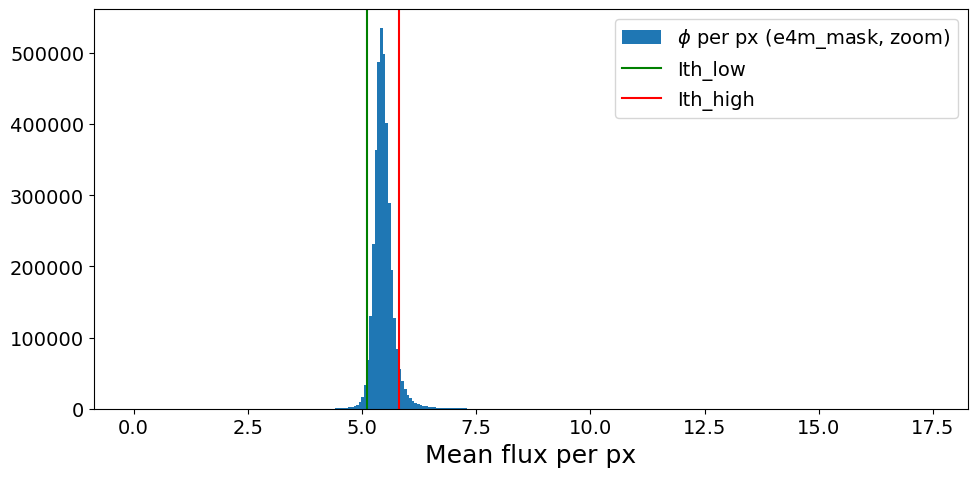

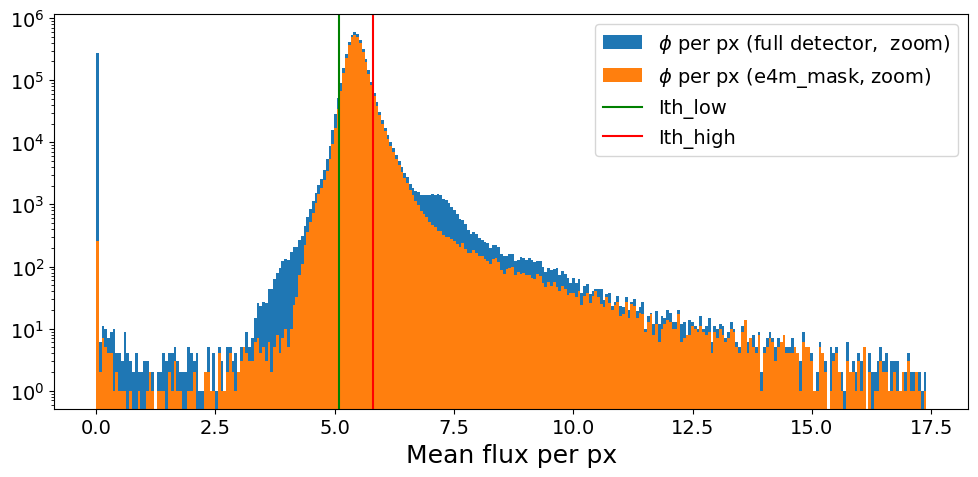

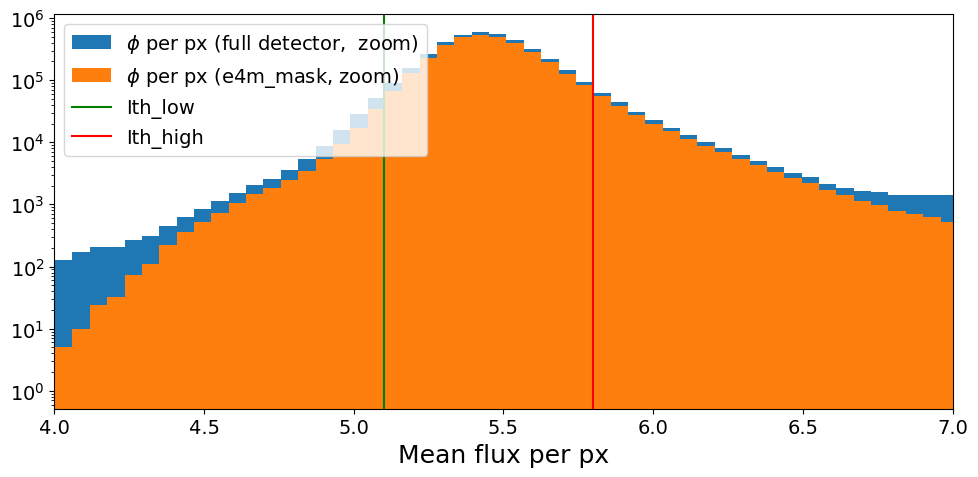

In [119]:
########################
Ith_low = 5.1
Ith_high = 5.8
########################

plt.figure(figsize=(10, 5))
plt.hist(Ip[e4m_mask], bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (e4m_mask, zoom)')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(Ip,           bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (full detector,  zoom)')
plt.hist(Ip[e4m_mask], bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (e4m_mask, zoom)')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(Ip,           bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (full detector,  zoom)')
plt.hist(Ip[e4m_mask], bins=300, range=(0, Ith_high*3), label='$\\phi$ per px (e4m_mask, zoom)')
plt.axvline(Ith_low, color='g', label='Ith_low')
plt.axvline(Ith_high, color='r', label='Ith_high')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.xlim(4, 7)
plt.tight_layout()
plt.show()

#### Higher trehsold map

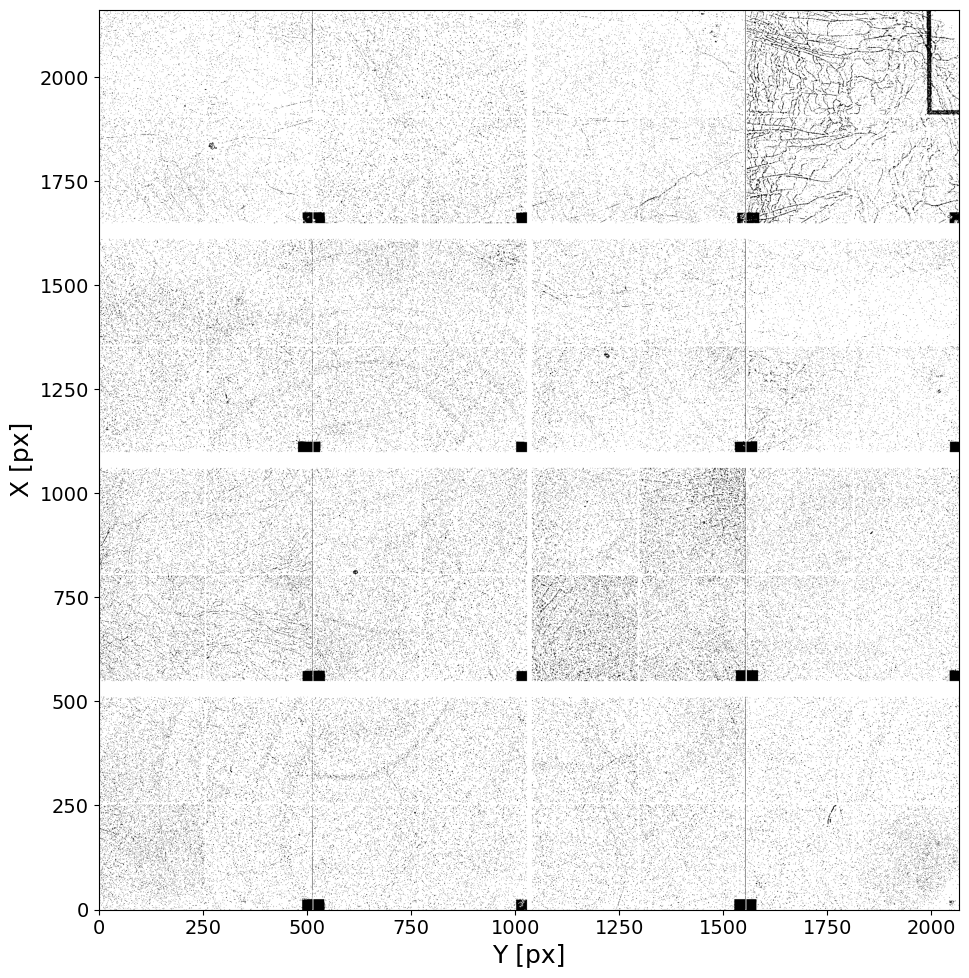

In [120]:
plt.figure(figsize=(10, 10))
plt.imshow(~(Ip>Ith_high).reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

#### Lower threshold map

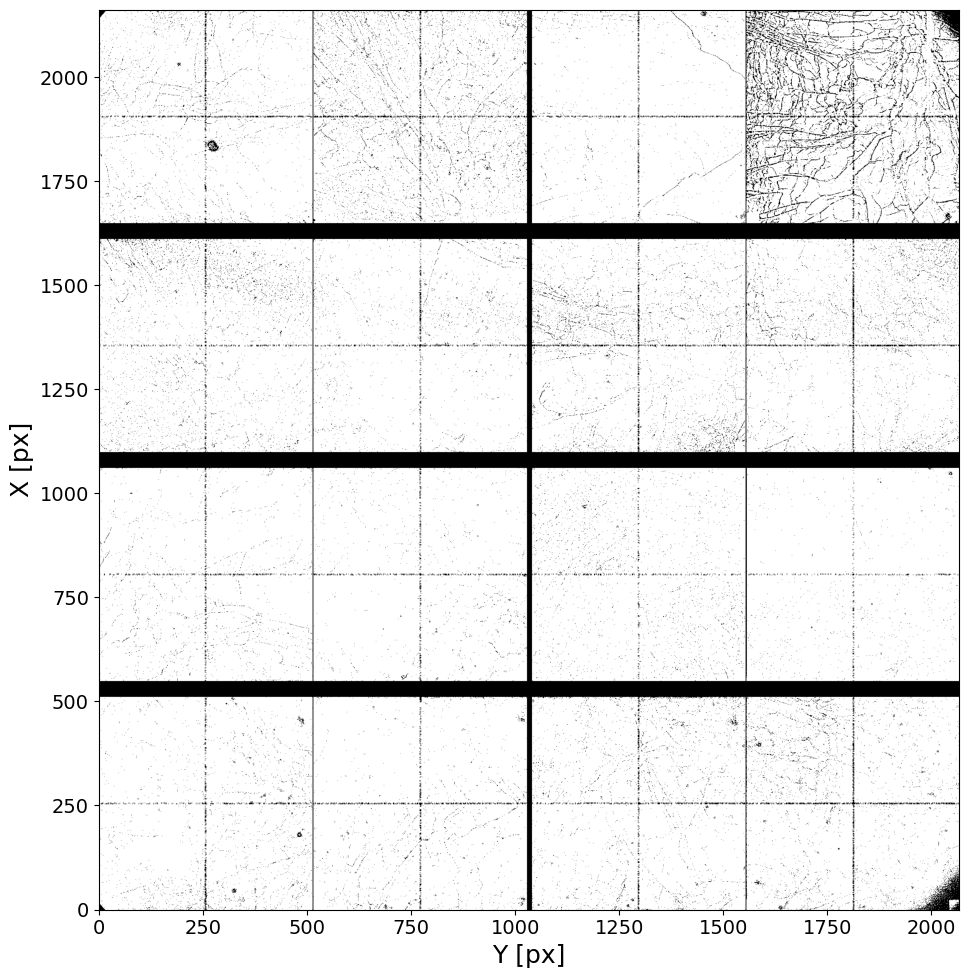

In [121]:
plt.figure(figsize=(10, 10))
plt.imshow(~(Ip<Ith_low).reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

In [122]:
e4mht_mask = (Ip>Ith_low) * (Ip<Ith_high)
np.save(MASKS_folder  + 'e4m_htmask_Mo_fluorescence.npy', e4mht_mask)

print('Percentage of pixels masked (where e4m_mask=True) =', (e4m_mask.sum()-(e4mht_mask*e4m_mask).sum())/e4m_mask.sum()*100)

Percentage of pixels masked (where e4m_mask=True) = 7.9181745093377165


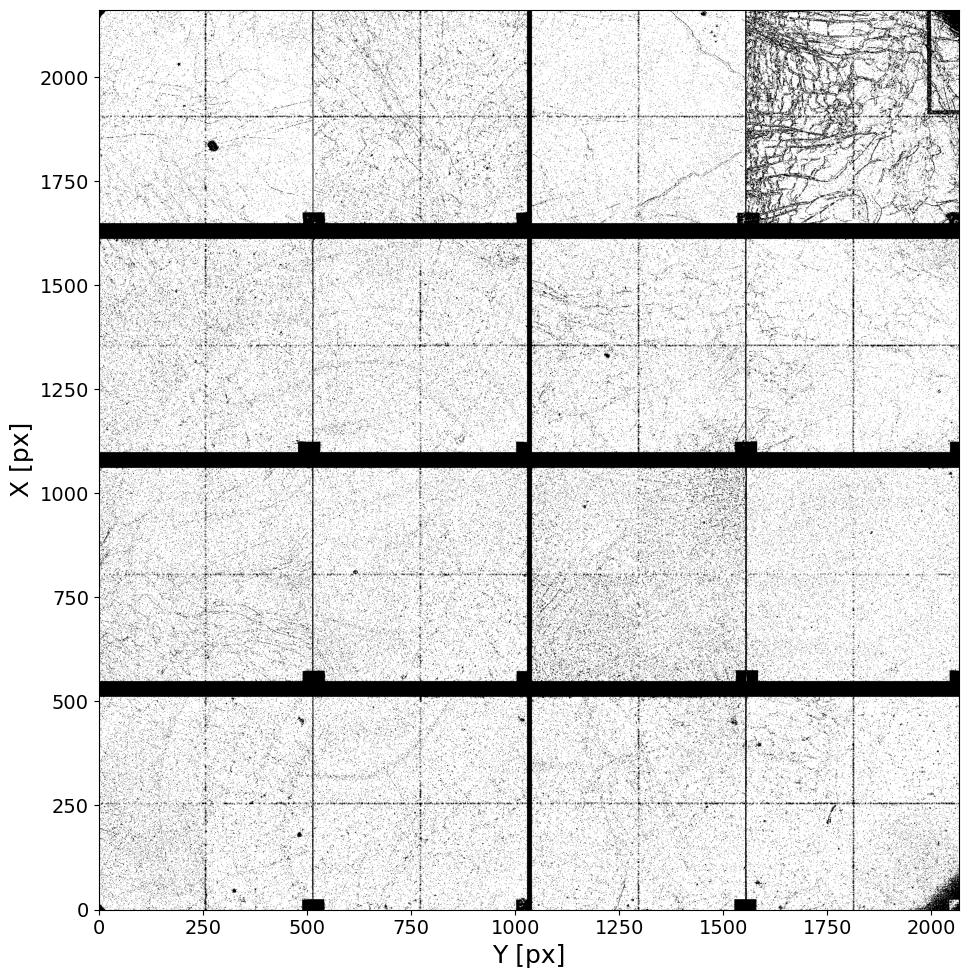

In [123]:
plt.figure(figsize=(10, 10))

plt.imshow(e4mht_mask.reshape(Nx, Ny), cmap='gray', origin='lower', alpha=1)
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout()
plt.show()

### 2.3) Check result on the last part of the scan

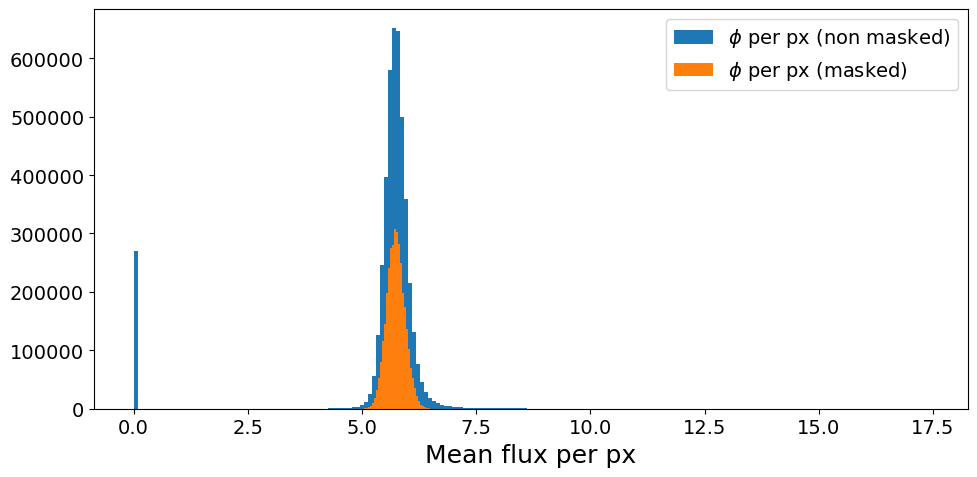

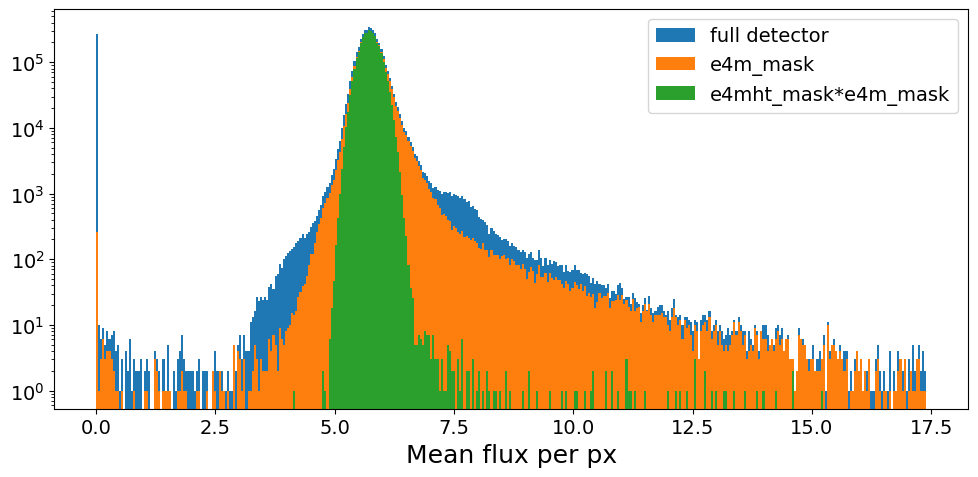

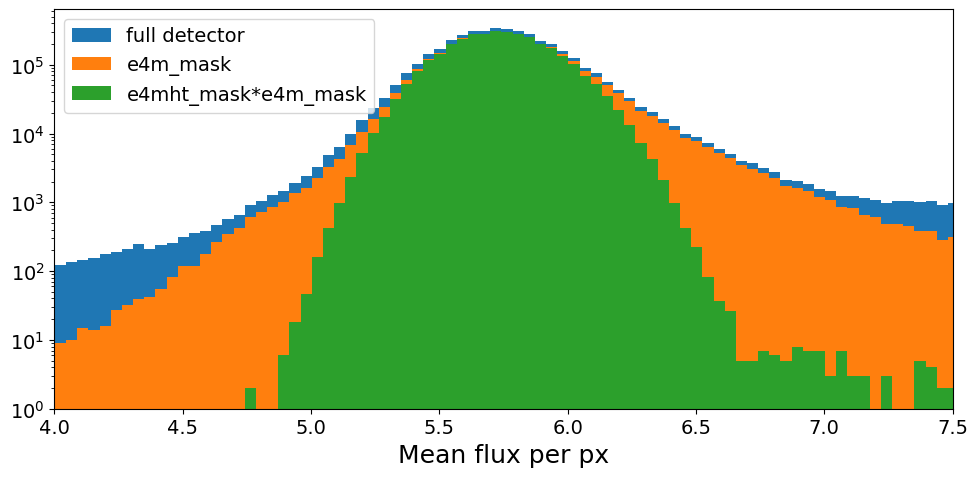

In [124]:
from scipy.stats import norm

plt.figure(figsize=(10, 5))
plt.hist(Ip_test, bins=200, range=(0, Ith_high*3), label='$\\phi$ per px (non masked)')
plt.hist(Ip_test[e4m_mask*e4mht_mask], bins=400, range=(0, Ith_high*3), label='$\\phi$ per px (masked)')
#plt.axvline(Ith_high, color='r', label='Ith_high')
#plt.axvline(Ith_low, color='g', label='Ith_low')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 5))
plt.hist(Ip_test,                      bins=400, range=(0, Ith_high*3), label='full detector')
plt.hist(Ip_test[e4m_mask],            bins=400, range=(0, Ith_high*3), label='e4m_mask')
plt.hist(Ip_test[e4m_mask*e4mht_mask], bins=400, range=(0, Ith_high*3), label='e4mht_mask*e4m_mask')
#plt.axvline(Ith_high, color='r', label='Ith_high')
#plt.axvline(Ith_low, color='g', label='Ith_low')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 5))
plt.hist(Ip_test,                      bins=400, range=(0, Ith_high*3), label='full detector')
plt.hist(Ip_test[e4m_mask],            bins=400, range=(0, Ith_high*3), label='e4m_mask')
plt.hist(Ip_test[e4m_mask*e4mht_mask], bins=400, range=(0, Ith_high*3), label='e4mht_mask*e4m_mask')
#plt.axvline(Ith_high, color='r', label='Ith_high')
#plt.axvline(Ith_low, color='g', label='Ith_low')
plt.yscale('log')
plt.xlabel('Mean flux per px')
plt.legend()
plt.xlim(4, 7.5)
plt.ylim(1)
plt.tight_layout(); plt.show()